In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-17 18:54:52--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 1423529 (1,4M) [text/plain]
Сохранение в: «housing.csv.3»

housing.csv.3       100%[===================>]   1,36M   736KB/s    за 1,9s    

2022-10-17 18:54:54 (736 KB/s) - «housing.csv.3» сохранён [1423529/1423529]



In [3]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

* Apply the log transform to median_house_value.
* train/validation/test split with 60%/20%/20% distribution.
* Use the train_test_split function and set the random_state parameter to 1.

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state = 1)
df_train, df_valid = train_test_split(df_full_train, test_size=0.25, random_state = 1)

In [5]:
# train/valid/test 
X_train = df_train.drop(['median_house_value'], axis = 1)
y_train = np.log1p(df_train['median_house_value'])

X_valid = df_valid.drop(['median_house_value'], axis = 1)
y_valid = np.log1p(df_valid['median_house_value'])

X_test = df_test.drop(['median_house_value'], axis = 1)
y_test = np.log1p(df_test['median_house_value'])

In [6]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
9107,-118.18,34.63,19.0,3562.0,606.0,1677.0,578.0,4.1573,INLAND
13999,-116.90,34.69,10.0,337.0,102.0,108.0,50.0,0.4999,INLAND
5610,-118.26,33.78,27.0,1672.0,491.0,1723.0,462.0,2.0458,NEAR OCEAN
13533,-117.33,34.17,5.0,4718.0,1140.0,2564.0,1056.0,2.9877,INLAND
2953,-119.02,35.35,42.0,1239.0,251.0,776.0,272.0,1.9830,INLAND


In [7]:
train_dict = X_train.to_dict(orient='records') 
valid_dict = X_valid.to_dict(orient='records') 
test_dict = X_test.to_dict(orient='records') 

dv = DictVectorizer(sparse = False)
dv.fit(train_dict)
X_train_fr_dict = dv.transform(train_dict)
X_valid_fr_dict = dv.transform(valid_dict)
X_test_fr_dict = dv.transform(test_dict)

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

In [8]:
dt = DecisionTreeRegressor(max_depth = 1)
dt.fit(X_train_fr_dict, y_train)

DecisionTreeRegressor(max_depth=1)

In [9]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



* n_estimators=10
* random_state=1
* n_jobs=-1 (optional - to make training faster)

In [10]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 1, n_jobs = -1)
rf.fit(X_train_fr_dict, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [11]:
pred = rf.predict(X_valid_fr_dict)
mse_train = np.sqrt(mean_squared_error(y_valid, pred))

print(round(mse_train,2))

0.25


Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
After which value of n_estimators does RMSE stop improving?

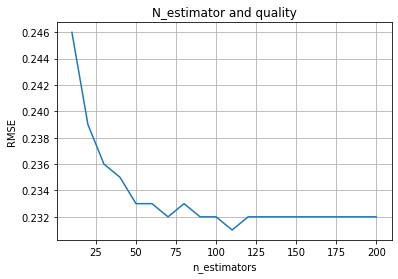

In [12]:
result = []

for number_trees in range(10,210,10):
    rf1 = RandomForestRegressor(n_estimators = number_trees, random_state = 1, n_jobs = -1)
    rf1.fit(X_train_fr_dict, y_train)
    
    pred1 = rf1.predict(X_valid_fr_dict)
    result.append(round(np.sqrt(mean_squared_error(y_valid, pred1)),3))
    
# graphs 
plt.plot([i for i in range(10,210,10)], result);
plt.title('N_estimator and quality');
plt.xlabel('n_estimators');
plt.ylabel('RMSE');
plt.grid(True);
    

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

In [ ]:
best_qual = 10

for depth in [10, 15, 20, 25]: 
    for n_est in [i for i in range(10,210,10)]: 
        rf1 = RandomForestRegressor(n_estimators = n_est, max_depth = depth, random_state = 1, n_jobs = -1)
        rf1.fit(X_train_fr_dict, y_train)
    
        pred1 = rf1.predict(X_valid_fr_dict)
        
        qual_cur = np.sqrt(mean_squared_error(y_valid, pred1))
        if best_qual > qual_cur:
            best_qual = qual_cur
            print('Глубина : {}, Кол-во  : {}, Качество : {}'.format(depth, n_est, qual_cur))

Глубина : 10, Кол-во  : 10, Качество : 0.25460133019342457
Глубина : 10, Кол-во  : 20, Качество : 0.25259936081647955
Глубина : 10, Кол-во  : 30, Качество : 0.25151411073705776
Глубина : 10, Кол-во  : 40, Качество : 0.25096319379208554
Глубина : 10, Кол-во  : 50, Качество : 0.2501170994722691
Глубина : 10, Кол-во  : 60, Качество : 0.2500355633598958
Глубина : 10, Кол-во  : 70, Качество : 0.2498733909205666
Глубина : 10, Кол-во  : 80, Качество : 0.24958462605555354
Глубина : 10, Кол-во  : 90, Качество : 0.24930989281483015
Глубина : 10, Кол-во  : 100, Качество : 0.24915323220209934
Глубина : 10, Кол-во  : 110, Качество : 0.24891931586008678
Глубина : 15, Кол-во  : 10, Качество : 0.24478232042926662
Глубина : 15, Кол-во  : 20, Качество : 0.2394329332606766
Глубина : 15, Кол-во  : 30, Качество : 0.23702152580570754
Глубина : 15, Кол-во  : 40, Качество : 0.2361599383141107
Глубина : 15, Кол-во  : 50, Качество : 0.23489942801278305
Глубина : 15, Кол-во  : 60, Качество : 0.23479802171481062


In [ ]:
rf1 = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1 )
rf1.fit(X_train_fr_dict, y_train)


In [ ]:
feat_import = []
for col, feat_imp in zip( dv.get_feature_names(), rf1.feature_importances_):
    feat_import.append((col, feat_imp))
    
sorted(feat_import, key = lambda x : -x[1])

In [ ]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train_fr_dict, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_valid_fr_dict, label=y_valid, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [ ]:
y_pred = model.predict(dval)

print(np.sqrt(mean_squared_error(y_valid, y_pred)))

In [ ]:
xgb_params = {  
    'eta': 0.1,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [ ]:
y_pred = model.predict(dval)

print(np.sqrt(mean_squared_error(y_valid, y_pred)))